# Assignment 1 - [Fazin Faizal]_[a1954220]

# Task 0: Data Visualization (0%, but encourage for understanding data)

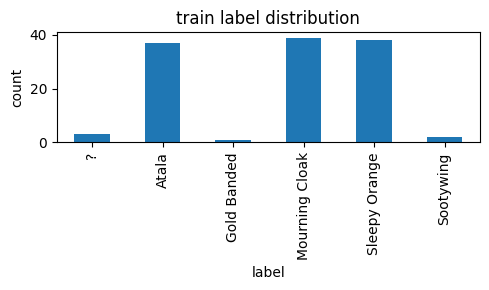

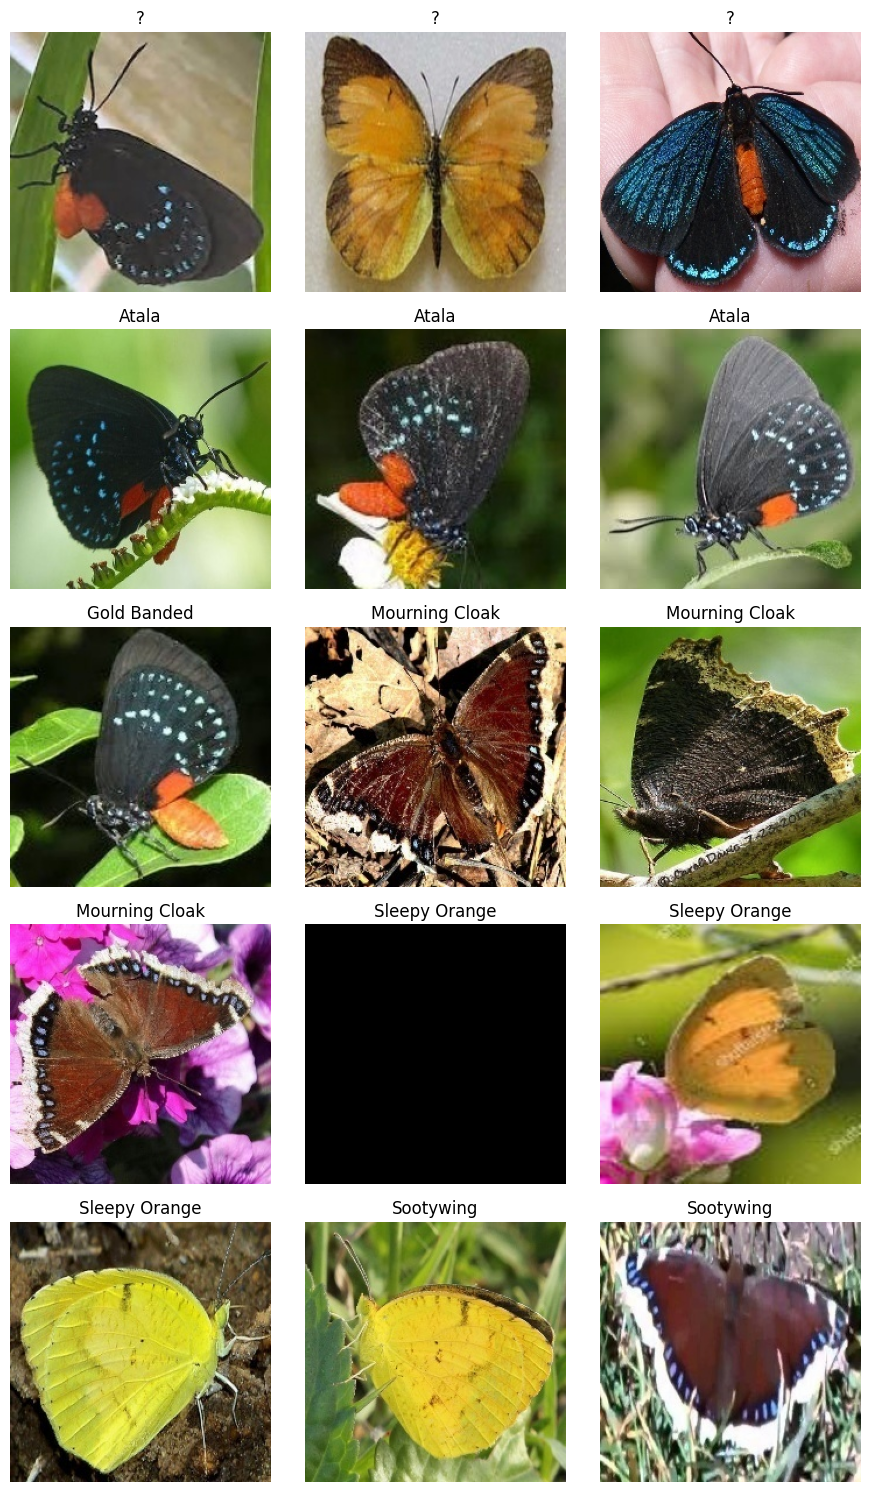

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

TRAIN_IMG_DIR = Path(r"C:\deepLearning\DeepLearning_Assignment_1-UoA\train")
TRAIN_CSV     = Path(r"C:\deepLearning\DeepLearning_Assignment_1-UoA\Train_label.csv")

# Read CSV with NO header, and name the columns explicitly
df = pd.read_csv(TRAIN_CSV, header=None, names=["filename", "label"])

# Clean up spacing/case so labels group properly in the chart
df["filename"] = df["filename"].astype(str).str.strip()
df["label"]    = df["label"].astype(str).str.strip().str.title()  # e.g., "sleepy orange" -> "Sleepy Orange"

# --- 0a) label distribution ---
ax = df["label"].value_counts().sort_index().plot(kind="bar", figsize=(5,3))
ax.set_xlabel("label"); ax.set_ylabel("count"); ax.set_title("train label distribution")
plt.tight_layout(); plt.show()

# --- 0b) tiny gallery: up to k images per class ---
k = 3
labels = sorted(df["label"].unique())
plt.figure(figsize=(3*k, 3*len(labels)))
idx = 1
for lab in labels:
    subset = df[df["label"] == lab].head(k)
    for _, r in subset.iterrows():
        plt.subplot(len(labels), k, idx); idx += 1
        img = Image.open(TRAIN_IMG_DIR / r["filename"]).convert("RGB")
        plt.imshow(img); plt.axis("off"); plt.title(lab)
plt.tight_layout(); plt.show()


# Task 1: Data Preprocessing

### 1.1 Data Cleaning (2%)

In [2]:
# write your code here, make sure you include 1 to 2 lines explanation on code
# Task 1.1 — Data Cleaning
# We normalize labels, drop unknowns/missing files, and save a clean CSV.

from PIL import Image

# normalize labels (merge case/spacing variants)
df["label"] = df["label"].astype(str).str.strip().str.title()

# remove unknown labels like "?"
df = df[df["label"] != "?"].copy()

# keep rows whose image file exists and opens
def is_readable(fn):
    p = TRAIN_IMG_DIR / str(fn)
    if not p.is_file():
        return False
    try:
        with Image.open(p) as im: im.verify()
        return True
    except Exception:
        return False

df["readable"] = df["filename"].map(is_readable)
clean_df = df[df["readable"]].drop(columns=["readable"]).reset_index(drop=True)

# encode labels -> integers (needed for CE loss later)
label2id = {lbl:i for i,lbl in enumerate(sorted(clean_df["label"].unique()))}
id2label = {v:k for k,v in label2id.items()}
clean_df["label_id"] = clean_df["label"].map(label2id)

# save for reproducibility
CLEAN_CSV = Path("./Train_label_clean.csv")
clean_df.to_csv(CLEAN_CSV, index=False)

print(f"Clean rows: {len(clean_df)} | classes: {len(label2id)} -> {label2id}")




Clean rows: 117 | classes: 5 -> {'Atala': 0, 'Gold Banded': 1, 'Mourning Cloak': 2, 'Sleepy Orange': 3, 'Sootywing': 4}


### 1.2 Data Processing (2%)

In [3]:
# write your code here, make sure you include 1 to 2 lines explanation on code

# Task 1.2 — Data Processing
# Define base transforms: resize small & convert to tensor in [0,1].

import torchvision.transforms as T

IMG_SIZE = (64, 64)  # small and fast for this assignment
base_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),  # [0,1]
    # Optional normalization (uncomment if requested):
    # T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])


### 1.3 Data Split and Loader (2%)

In [6]:
%pip install --quiet scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [9]:
# Task 1.3 — Data Split & Loader (Windows-safe)
# We use num_workers=0 to avoid multiprocessing issues on Windows,
# then sanity-check one batch and (optional) scan for any bad files.

from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pathlib import Path

# --- assumes you already have: clean_df (with filename, label_id), TRAIN_IMG_DIR, base_transform ---

# Robust per-class split (keeps at least 1 in train)
VAL_FRAC = 0.2
rng = 1954220
val_indices = []
for cls, g in clean_df.groupby("label_id"):
    n = len(g)
    if n == 1:
        continue
    elif n == 2:
        val_n = 1
    else:
        val_n = max(1, int(round(n * VAL_FRAC)))
        val_n = min(val_n, n - 1)
    val_indices.extend(g.sample(n=val_n, random_state=rng).index)

val_part   = clean_df.loc[val_indices].reset_index(drop=True)
train_part = clean_df.drop(val_indices).reset_index(drop=True)

print("Train/Val sizes:", len(train_part), len(val_part))

class ImageCSVDataset(Dataset):
    def __init__(self, df, root: Path, transform=None):
        self.df = df.reset_index(drop=True)
        self.root = Path(root)
        self.transform = transform
    def __len__(self): 
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(self.root / str(row["filename"])).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, int(row["label_id"])

# --- Windows-safe DataLoaders (no multiprocessing) ---
BATCH_SIZE = 32
train_ds = ImageCSVDataset(train_part, TRAIN_IMG_DIR, transform=base_transform)
val_ds   = ImageCSVDataset(val_part,   TRAIN_IMG_DIR, transform=base_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# quick sanity check: fetch one batch
xb, yb = next(iter(train_loader))
print("Batch:", xb.shape, "| Labels:", yb.shape, "| Label range:", int(yb.min()), "→", int(yb.max()))

# OPTIONAL: find first bad training sample if something still fails
# (run only if you get errors when iterating the loader)
for i in range(len(train_ds)):
    try:
        _ = train_ds[i]
    except Exception as e:
        bad = train_ds.df.iloc[i]
        print("Bad sample at idx", i, "| file:", bad["filename"], "| error:", e)
        break
else:
    print("All training samples load fine.")


Train/Val sizes: 93 24
Batch: torch.Size([32, 3, 64, 64]) | Labels: torch.Size([32]) | Label range: 0 → 3
All training samples load fine.


### 1.4 Data Augmentation

In [10]:
# Task 1.4 — Data Augmentation
# Light, label-preserving augmentations applied to the TRAIN set only.

train_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=10),
    T.ToTensor(),
])

# Recreate only the training dataset/loader with augmentations
train_ds = ImageCSVDataset(train_part, TRAIN_IMG_DIR, transform=train_transform)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)


# Task 2: Training Loop (7%)

### 2.1 Model Architecture (2%)

In [11]:
# Task 2.1 — Simple CNN from basic layers (no pretrained)
import torch
import torch.nn as nn

NUM_CLASSES = int(max(train_part["label_id"].max(), val_part["label_id"].max())) + 1

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                         # 64 -> 32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                         # 32 -> 16
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),                 # -> (B,128,1,1)
        )
        self.head = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x).view(x.size(0), -1)
        return self.head(x)

model = SimpleCNN()
sum(p.numel() for p in model.parameters() if p.requires_grad)


93893

### 2.2 Training Loop (5%)

In [ ]:
# ===== Windows-safe training run (rebuild loaders, train 1 epoch, diagnose if needed) =====
from torch.utils.data import DataLoader
import torch, torch.nn as nn, torch.optim as optim

# --- 0) Rebuild DataLoaders with NO multiprocessing (fixes worker crash on Windows) ---
BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

# quick sanity check for a batch
xb, yb = next(iter(train_loader))
print("Batch OK:", xb.shape, "| Labels:", yb.shape)

# --- 1) Model (use existing if defined; otherwise define a minimal CNN) ---
if "model" not in globals() or model is None:
    NUM_CLASSES = int(max(train_part["label_id"].max(), val_part["label_id"].max())) + 1
    class SimpleCNN(nn.Module):
        def __init__(self, num_classes=NUM_CLASSES):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(inplace=True),
                nn.MaxPool2d(2),                         # 64 -> 32
                nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
                nn.MaxPool2d(2),                         # 32 -> 16
                nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(1),                 # -> (B,128,1,1)
            )
            self.head = nn.Linear(128, num_classes)
        def forward(self, x):
            x = self.features(x).view(x.size(0), -1)
            return self.head(x)
    model = SimpleCNN()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# --- 2) Training utils ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss, correct, total = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)
            total_loss += loss.item() * yb.size(0)

    return total_loss / max(1,total), correct / max(1,total)

# --- 3) Train 1 epoch (per assignment FAQ, correctness > long training) ---
EPOCHS = 1
for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    va_loss, va_acc = run_epoch(val_loader,   train=False)
    print(f"Epoch {ep:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | val loss {va_loss:.4f} acc {va_acc:.3f}")



Batch OK: torch.Size([32, 3, 64, 64]) | Labels: torch.Size([32])
Epoch 01 | train loss 1.6156 acc 0.108 | val loss 1.5851 acc 0.417
